Merged shape: (1068, 935)
T1-Ac shape: (79, 935)
1    15
2     7
3    29
4    28
Name: group, dtype: int64 

Train size: (55, 928)   Test size: (24, 928) 

Train label counts:
 1    10
2     5
3    20
4    20
dtype: int64 

Test  label counts:
 1    5
2    2
3    9
4    8
dtype: int64 

Chosen k via CV (T1-Ac): 3  [mean macro F1 on train CV = 0.166]

Macro F1 score: 0.2818452380952381 

Confusion matrix:
 [[1 0 3 1]
 [0 1 0 1]
 [3 0 3 3]
 [1 4 1 2]] 

Classification report:
               precision    recall  f1-score   support

           1       0.20      0.20      0.20         5
           2       0.20      0.50      0.29         2
           3       0.43      0.33      0.38         9
           4       0.29      0.25      0.27         8

    accuracy                           0.29        24
   macro avg       0.28      0.32      0.28        24
weighted avg       0.31      0.29      0.29        24


y_test  vs  y_pred  (T1-Ac):
     y_test  y_pred
1        3       1
2        3      

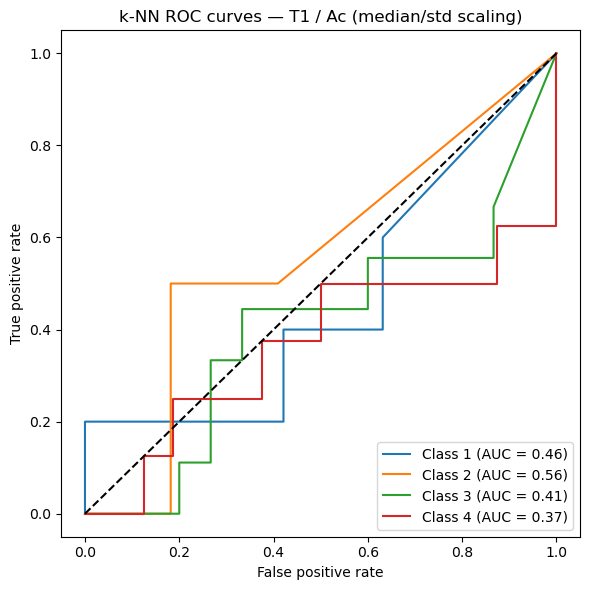

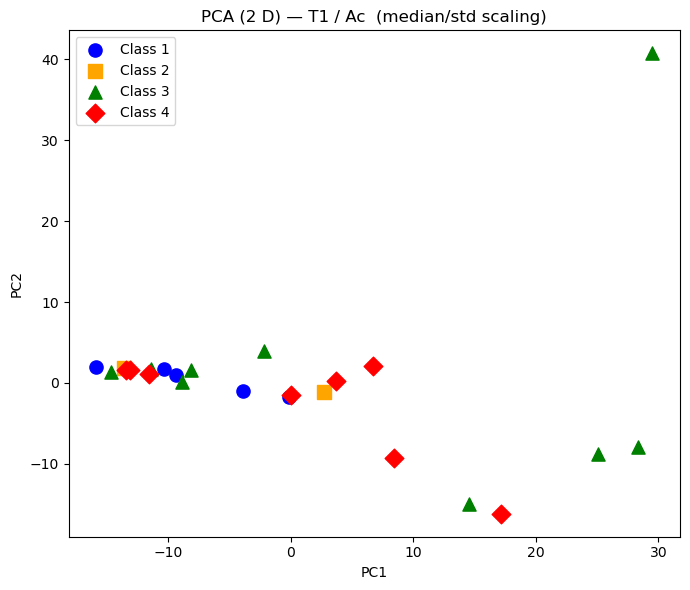

In [4]:
# ===============================================================
#  k-NN — T1 / Antecubital fossa (Ac)
#  Workflow: load → merge → subset → split → auto-k → train → eval
#  Scaling: median / std ONLY  (NO log)
# ===============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.exceptions            import UndefinedMetricWarning
from sklearn.model_selection       import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing         import FunctionTransformer, label_binarize
from sklearn.pipeline              import Pipeline
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.metrics               import (f1_score, confusion_matrix,
                                           classification_report,
                                           roc_curve, auc)
from sklearn.decomposition         import PCA

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# ----------------------------------------------------------------
# 1. LOAD + MERGE
# ----------------------------------------------------------------
df_micro = (pd.read_csv("Vitality_microbialAbundance_table.csv")
              .rename(columns={"Unnamed: 0": "met_id"}))
df_meta  = (pd.read_csv("Vitality_metadata_table.csv")
              .rename(columns={"Unnamed: 0": "met_id"}))

meta_cols = ["met_id", "subject_id", "site_specific", "visit", "group",
             "group_eczemaYesOrNo", "group_eczema_affectedSkin"]

df = df_micro.merge(df_meta[meta_cols], on="met_id", how="inner")
print("Merged shape:", df.shape)

# ----------------------------------------------------------------
# 2. SUBSET  ►  T1  +  Ac
# ----------------------------------------------------------------
mask     = (df["visit"] == "T1") & (df["site_specific"] == "Ac")
df_t1_ac = df.loc[mask].reset_index(drop=True)

print("T1-Ac shape:", df_t1_ac.shape)
print(df_t1_ac["group"].value_counts().sort_index(), "\n")

# ----------------------------------------------------------------
# 3. TRAIN / TEST SPLIT  (70 / 30, stratified)
# ----------------------------------------------------------------
drop_cols = ["met_id", "subject_id",
             "site_specific", "visit", "group",
             "group_eczemaYesOrNo", "group_eczema_affectedSkin"]

feature_cols = [c for c in df_t1_ac.columns if c not in drop_cols]

train_df, test_df = train_test_split(
    df_t1_ac,
    test_size=0.30,
    stratify=df_t1_ac["group"],
    random_state=42
)

X_train = train_df[feature_cols].values.astype(float)
y_train = train_df["group"].values
X_test  = test_df[feature_cols].values.astype(float)
y_test  = test_df["group"].values

print("Train size:", X_train.shape, "  Test size:", X_test.shape, "\n")

print("Train label counts:\n",
      pd.Series(y_train).value_counts().sort_index(), "\n")
print("Test  label counts:\n",
      pd.Series(y_test).value_counts().sort_index(), "\n")

# ----------------------------------------------------------------
# 4. MEDIAN / STD SCALING  (NO log)
# ----------------------------------------------------------------
def median_std_only(X):
    X   = X.astype(float)
    med = np.median(X, axis=0)
    std = np.std   (X, axis=0)
    std[std == 0] = 1.0
    return (X - med) / std

median_std_tf = FunctionTransformer(median_std_only)

# ----------------------------------------------------------------
# 5. AUTO-SELECT k VIA 5-FOLD CV ON TRAINING SET
# ----------------------------------------------------------------
candidate_k = [3, 5, 7, 9]
best_k = None
best_score = -1.0

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for k in candidate_k:
    tmp_pipe = Pipeline([
        ("scale", median_std_tf),
        ("knn",   KNeighborsClassifier(n_neighbors=k, weights="distance"))
    ])
    scores = cross_val_score(
        tmp_pipe, X_train, y_train,
        cv=cv, scoring="f1_macro"
    )
    mean_score = scores.mean()
    if mean_score > best_score:
        best_score = mean_score
        best_k = k

print(f"Chosen k via CV (T1-Ac): {best_k}  "
      f"[mean macro F1 on train CV = {best_score:.3f}]\n")

# ----------------------------------------------------------------
# 6. FINAL PIPELINE  (median/std → k-NN with best k)
# ----------------------------------------------------------------
pipe = Pipeline([
    ("scale", median_std_tf),
    ("knn",   KNeighborsClassifier(n_neighbors=best_k, weights="distance"))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# ----------------------------------------------------------------
# 7. METRICS
# ----------------------------------------------------------------
print("Macro F1 score:", f1_score(y_test, y_pred, average="macro"), "\n")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred), "\n")
print("Classification report:\n",
      classification_report(y_test, y_pred, zero_division=0))

# ----------------------------------------------------------------
# 8. y_test vs y_pred TABLE  (1-based index)
# ----------------------------------------------------------------
tbl = pd.DataFrame({"y_test": y_test, "y_pred": y_pred})
tbl.index = np.arange(1, len(tbl) + 1)
print("\ny_test  vs  y_pred  (T1-Ac):\n", tbl.to_string(), "\n")

# ----------------------------------------------------------------
# 9. MIS-CLASSIFIED ROWS (with eczema tags)
# ----------------------------------------------------------------
mis_idx = np.where(y_test != y_pred)[0]
chk = (test_df.iloc[mis_idx][
          ["met_id", "group",
           "group_eczemaYesOrNo", "group_eczema_affectedSkin"]]
       .assign(y_test=y_test[mis_idx],
               y_pred=y_pred[mis_idx]))
chk.index = np.arange(1, len(chk) + 1)

print("Mis-classified rows — check 1_yes, 3_yes_no tags etc.:\n",
      chk.to_string(), "\n")

# ----------------------------------------------------------------
# 10. ROC CURVES  (one-vs-rest)
# ----------------------------------------------------------------
classes = np.sort(np.unique(y_train))
y_bin   = label_binarize(y_test, classes=classes)
y_prob  = pipe.predict_proba(X_test)

plt.figure(figsize=(6, 6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("k-NN ROC curves — T1 / Ac (median/std scaling)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------
# 11. PCA (2D) on SCALED TEST SET
# ----------------------------------------------------------------
X_test_std = median_std_tf.transform(X_test)
X_2d       = PCA(n_components=2).fit_transform(X_test_std)

mk = {1: "o", 2: "s", 3: "^", 4: "D"}
cl = {1: "blue", 2: "orange", 3: "green", 4: "red"}

plt.figure(figsize=(7, 6))
for c in np.unique(y_test):
    idx = (y_test == c)
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1],
                c=cl[c], marker=mk[c], s=90, label=f"Class {c}")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (2 D) — T1 / Ac  (median/std scaling)")
plt.legend()
plt.tight_layout()
plt.show()